In [77]:
import pandas as pd
from pandas import concat
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import concatenate
import keras
from keras.models import Sequential
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, datetime
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.layers import LSTM
import tensorflow as tf
import matplotlib.pyplot as plt


df = pd.read_csv('paris_data_3.csv')
temperature = df['T2M']  # centigrade
humidity = df['RH2M']  # percent
pressure = df['PS']  # Kpa
min_temp = df['T2M_MIN']
max_temp = df['T2M_MAX']
dew_temp = df['T2MDEW']
all_sky_insolation = ['ALLSKY_SFC_SW_DWN']


raw = DataFrame()
raw['ob1'] = [i for i in temperature]
raw['ob2'] = [i for i in humidity]
raw['ob3'] = [i for i in pressure]
raw['ob4'] = [i for i in min_temp]
raw['ob5'] = [i for i in max_temp]
raw['ob6'] = [i for i in dew_temp]

values = raw.values
values = values.astype('float32')

In [78]:
# define a function to change the data format from series to supervised-type
def change_format(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


reframe = change_format(values, 5, 1)
reframe.drop(reframe.columns[31:36], axis=1, inplace=True)

values = reframe.values
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

n_train_steps = 13500
train = values[:n_train_steps, :]
test = values[n_train_steps:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [82]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10,
                 strides=1, padding="causal",
                 activation="sigmoid"))
model.add(
    LSTM(
        64,
        input_shape=(
            train_X.shape[1],
            train_X.shape[2]),
        return_sequences=True))
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))

model_of_temperature = model


model_of_temperature.compile(loss=tf.keras.losses.Huber(),
    optimizer='adam',
    metrics=["mae"])
h = model_of_temperature.fit(
    train_X,
    train_y,
    validation_split=0.2,
    epochs=10,
    batch_size=20)

Train on 10800 samples, validate on 2700 samples
Epoch 1/10
10800/10800 [==============================] - 7s 608us/step - loss: 0.0083 - mae: 0.0859 - val_loss: 0.0014 - val_mae: 0.0411
Epoch 2/10
10800/10800 [==============================] - 6s 527us/step - loss: 0.0014 - mae: 0.0427 - val_loss: 0.0020 - val_mae: 0.0504
Epoch 3/10
10800/10800 [==============================] - 6s 511us/step - loss: 0.0012 - mae: 0.0390 - val_loss: 0.0023 - val_mae: 0.0556
Epoch 4/10
10800/10800 [==============================] - 6s 525us/step - loss: 0.0011 - mae: 0.0372 - val_loss: 0.0010 - val_mae: 0.0353
Epoch 5/10
10800/10800 [==============================] - 6s 519us/step - loss: 0.0010 - mae: 0.0358 - val_loss: 9.2038e-04 - val_mae: 0.0336
Epoch 6/10
10800/10800 [==============================] - 6s 523us/step - loss: 0.0010 - mae: 0.0355 - val_loss: 0.0010 - val_mae: 0.0367
Epoch 7/10
10800/10800 [==============================] - 6s 529us/step - loss: 0.0010 - mae: 0.0355 - val_loss: 8.9651

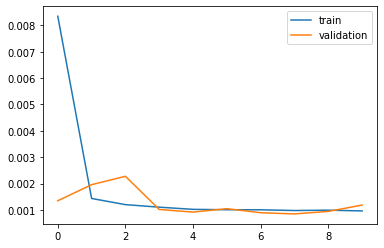

In [83]:
plt.plot(h.history['loss'], label='train')

plt.plot(h.history['val_loss'], label='validation')
plt.legend()
plt.show()

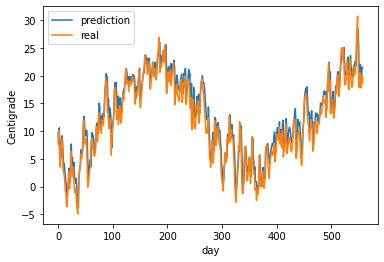

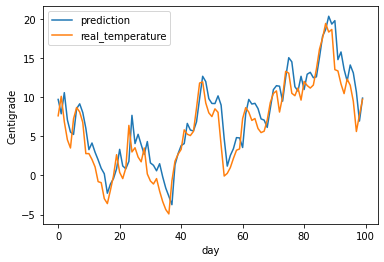

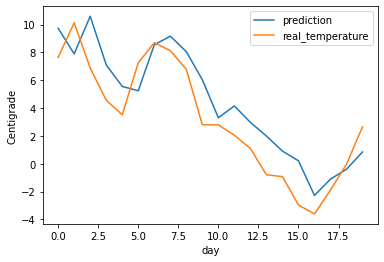

In [84]:
yhat = model_of_temperature.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((yhat, yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_y, test_X_reshaped[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
plt.plot(inv_yhat, label='prediction')
plt.plot(inv_y, label='real')
plt.xlabel('day')
plt.ylabel('Centigrade')
plt.legend()
plt.show()
plt.plot(inv_yhat[:100], label='prediction')
plt.plot(inv_y[:100], label='real_temperature')
plt.xlabel('day')
plt.ylabel('Centigrade')
plt.legend()
plt.show()
plt.plot(inv_yhat[:20], label='prediction')
plt.plot(inv_y[:20], label='real_temperature')
plt.xlabel('day')
plt.ylabel('Centigrade')
plt.legend()
plt.show()